# Load the data

In [1]:
!pip install pandas seaborn matplotlib numpy imblearn mlflow[extras] boto3 awscli --quiet

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/Users/ltsai/Documents/workspace/github/datascience-examples/creditcard.csv')

In [4]:
features = df.columns.values

# Finding features with the highest correlation

In [5]:
def most_corr(param, n):
    class_corr = df.corr()[param].sort_values(ascending=False)
    list_class = []
    for i in features:
        if(np.abs(class_corr[i]) >= n): 
           list_class.append(i)
    return list_class
# Select features with correlation higher than 0.1 (positive correlation) or lower than -0.1 (negative correlation)
selected_features = most_corr('Class', 0.1)
selected_features

['V1',
 'V3',
 'V4',
 'V7',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'Class']

In [6]:
dataset = df[selected_features]

# Building your first baseline Logistic Regression model

In [7]:
from sklearn.model_selection import train_test_split
#precision_recall_curve, from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import classification_report, recall_score, precision_score, \
    average_precision_score, precision_recall_curve, plot_precision_recall_curve, f1_score, auc, \
    roc_curve, roc_auc_score, confusion_matrix, accuracy_score

In [8]:
RANDOM_SEED = 42

In [9]:
TEST_SIZE = 0.3

## Split the data into X and y

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Class',1) , dataset['Class'], test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [11]:
X_train.shape

(199364, 11)

In [12]:
X_test.shape

(85443, 11)

In [13]:
# test_size
round(X_test.shape[0]/df.shape[0], 2)

0.3

In [14]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
resampling = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)

baseline = LogisticRegression()
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', baseline)])

classifiers = [{'name': 'baseline', 'model': baseline}] + [{'name': 'smote', 'model': pipeline}]

In [15]:
for classifier in classifiers:
    print('======')
    print(classifier['name'])
    model = classifier['model']
    model.fit(X_train, y_train)

    # Obtain model predictions
    y_baseline = model.predict(X_test)

    # Probabilities 
    y_proba_baseline = model.predict_proba(X_test)[:,1]
    average_precision = average_precision_score(y_test, y_proba_baseline)
    
    classifier['y_baseline'] = y_baseline
    classifier['y_proba_baseline'] = y_proba_baseline
    classifier['average_precision'] = average_precision

baseline
smote


In [16]:
for classifier in classifiers:
    print('=====')
    print(classifier['name'])
    print(classification_report(y_test, classifier['y_baseline']))
    print('\n')
    print('AUC: {}%'.format(roc_auc_score(y_test, classifier['y_proba_baseline'])))
    print('Precision-Recall: {}'.format(classifier['average_precision']))
    print('\n')

=====
baseline
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.62      0.72       136

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



AUC: 0.9752728725799346%
Precision-Recall: 0.767695758241322


=====
smote
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85307
           1       0.05      0.92      0.10       136

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.54     85443
weighted avg       1.00      0.97      0.98     85443



AUC: 0.9805122967634543%
Precision-Recall: 0.7694974622008761




## AUC - ROC Curve

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

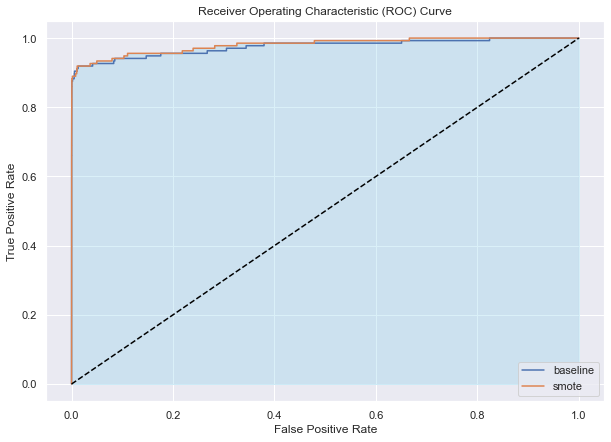

In [18]:
plt.figure(figsize = (10,7))
for classifier in classifiers:
    fpr, tpr, thresholds = roc_curve(y_test, classifier['y_proba_baseline'])
    #plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot(fpr, tpr, label=classifier['name'])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.fill_between(fpr, tpr, color='skyblue', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Plot the Precision-Recall curve

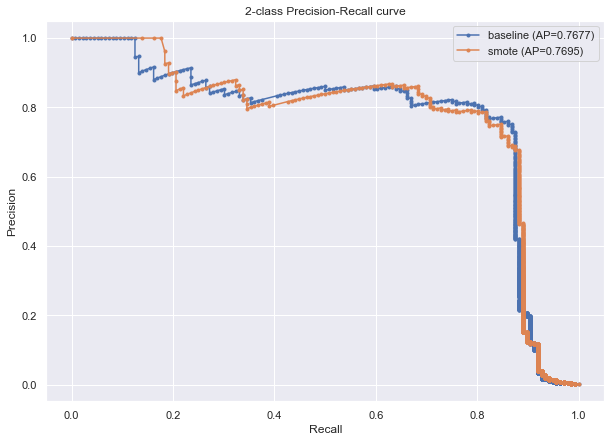

In [19]:
# For unbalanced data
plt.figure(figsize = (10,7))

for classifier in classifiers:
    precision, recall, a = precision_recall_curve(y_test, classifier['y_proba_baseline'])
    plt.plot(recall, precision, marker='.', label=classifier['name'] + ' (AP={:.4f})'.format(classifier['average_precision']))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve')
plt.legend()
plt.show()

## Confusion Matrix

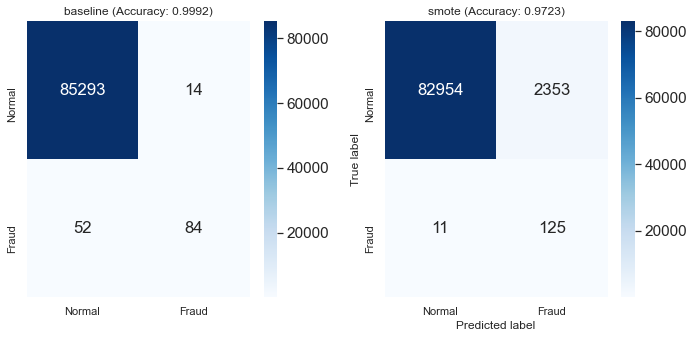

In [20]:
LABELS = ["Normal", "Fraud"]

#THRESHOLD=0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for cls, ax in zip(classifiers, axes.flatten()):
    cm = confusion_matrix(y_test, cls['y_baseline']) # rows = truth, cols = prediction    
    #cm = confusion_matrix(y_test, np.where(cls['y_proba_baseline'] > THRESHOLD, 1, 0))
    df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))

    ax.title.set_text('{} (Accuracy: {:.4f})'.format(cls['name'], accuracy_score(y_test, cls['y_baseline'])))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, xticklabels=LABELS, yticklabels=LABELS, ax=ax, annot=True, fmt="d", cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.tight_layout()  
plt.show()